In [1]:
%matplotlib inline

## [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)
- Finds a low-D representation of the affinity matrix between samples, followed by K-Means clustering of the eigenvector components in the low-D space.
- Computationally efficient if the affinity matrix is sparse and the ```amg``` solver is used for the eigenvalue computations. (This requires the [pyamg](https://github.com/pyamg/pyamg) module to be installed.)
- **Label Assignments** using ```assign_labels``` param:
    - "kmeans": matches finer details but can be unstable.
    - "discretize": 100% reproduceable; tends to build parcels of even / geometric shapes.

## Example: Image Segmentation
- generate image with connected circles
- use spectral clustering to separate the circles

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l       = 100
x, y    = np.indices((l, l))
center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2


In [3]:
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)
img  = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert image to a graph with the value of the gradient on the edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Use arpack solver - amg is numerically unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels


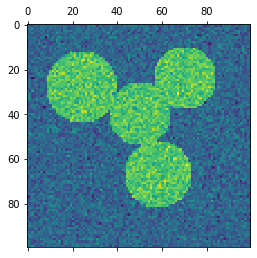

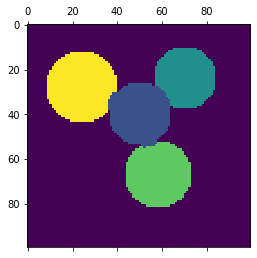

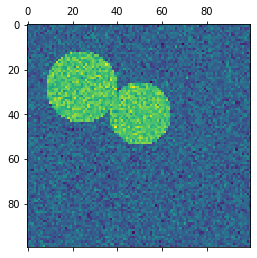

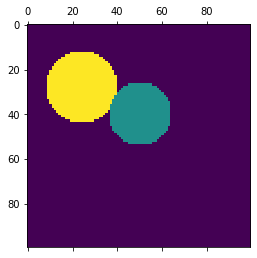

In [4]:
plt.matshow(img)
plt.matshow(label_im)

img            = circle1 + circle2
mask           = img.astype(bool)
img            = img.astype(float)
img           += 1 + 0.2 * np.random.randn(*img.shape)
graph          = image.img_to_graph(img, 
                                    mask=mask)
graph.data     = np.exp(-graph.data / graph.data.std())
labels         = spectral_clustering(graph, 
                                     n_clusters=2, 
                                     eigen_solver='arpack')
label_im       = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

## Example: segment coin pictures with Spectral Clustering
- Use SC on a graph created from image [voxel-to-voxel](https://en.wikipedia.org/wiki/Voxel)  differences to break it into multiple partly-homogeneous regions
- This is an approximate solution for finding [normalized graph cuts](https://en.wikipedia.org/wiki/Graph_cuts_in_computer_vision).
- Two options for assigning labels:
    - 1) 'kmeans': K-means clustering
    - 2) 'discrete': iteratively search for closest partition spaces

In [5]:
import time

import numpy as np
from distutils.version          import LooseVersion
from scipy.ndimage.filters      import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data               import coins
from skimage.transform          import rescale
from sklearn.feature_extraction import image
from sklearn.cluster            import spectral_clustering

In [6]:
# these were introduced in skimage-0.14
if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

Spectral clustering: kmeans, 8.11s
Spectral clustering: discretize, 4.85s


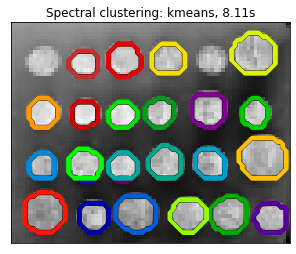

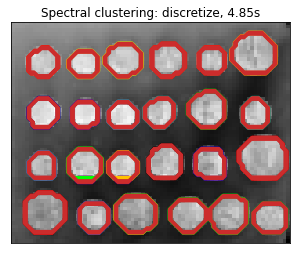

In [7]:
orig_coins = coins() # load the coins as a numpy array

# Resize to 20% to speed up processing
# Using a Gaussian filter for smoothing prior to down-scaling reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins   = rescale(smoothened_coins, 
                           0.2, 
                           mode="reflect",
                         **rescale_params)

# Convert image into graph with gradient value on the edges.
graph = image.img_to_graph(rescaled_coins)   

# Take a decreasing function of the gradient: an exponential
# smaller beta = more independent segmentation is of actual image. 
# For beta=1, the segmentation is close to a voronoi.

beta       = 10
eps        = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply SC (much faster if you have pyamg installed)
N_REGIONS = 25

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, 
                                 n_clusters=N_REGIONS,
                                 assign_labels=assign_labels, 
                                 random_state=42)
    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, 
               cmap=plt.cm.gray)

    for l in range(N_REGIONS):
        plt.contour(labels == l,
                    colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()